# Задание

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-05-01 по 2023-05-07 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from scipy import stats
import plotly.express as px
import numpy as np
from scipy import stats
import datetime
from datetime import timedelta
from datetime import datetime as dt
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm
from scipy.stats import norm
import pandahouse as ph

In [2]:
#выставим настройки графика
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
#создаем подключение
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230520',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
#делаем выгрузку
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


---
Оцениваем распределение выборок

---

<AxesSubplot:xlabel='ctr', ylabel='Count'>

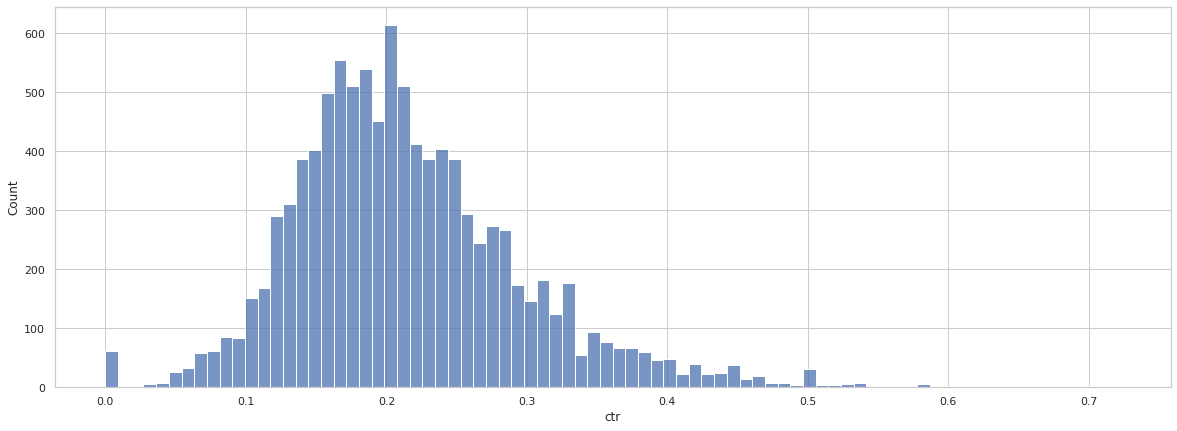

In [5]:
sns.histplot(df.query('exp_group == 1').ctr)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

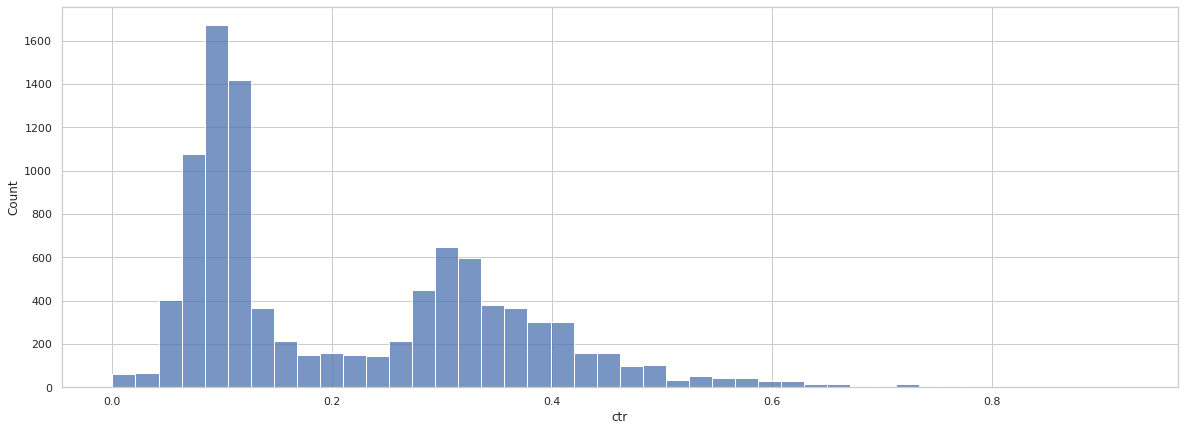

In [6]:
sns.histplot(df.query('exp_group == 2').ctr)

> По выборкам видно что группа 2 не иммеет нормального распределения. Тем не менее проведем t-test, Манна-Уитни, бутстрап и пуасоновский бутстрап

---
### t-тест

---

In [7]:
# t-test
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

---
### критерий Манна-Уитни

---

In [8]:
# критерий манна-уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

---
### Сглаженный CTR

---

In [9]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

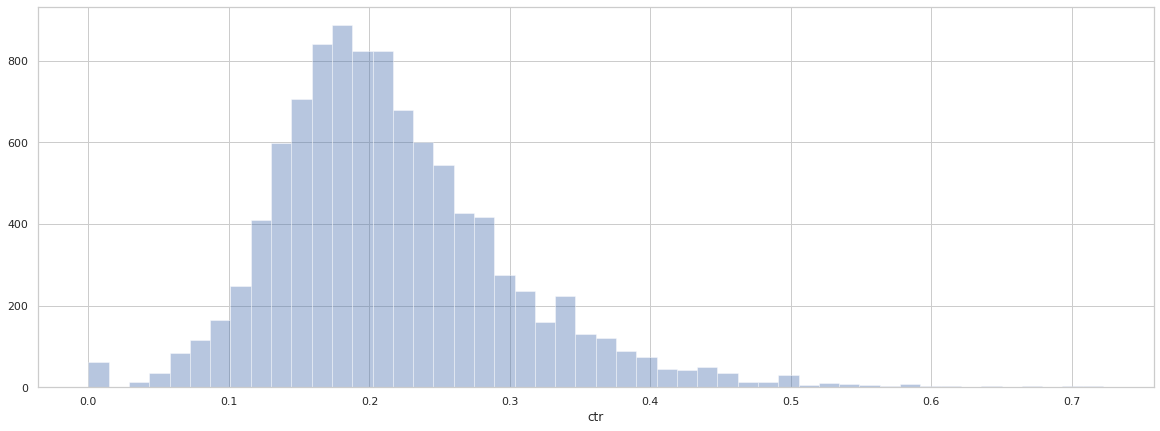

In [10]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

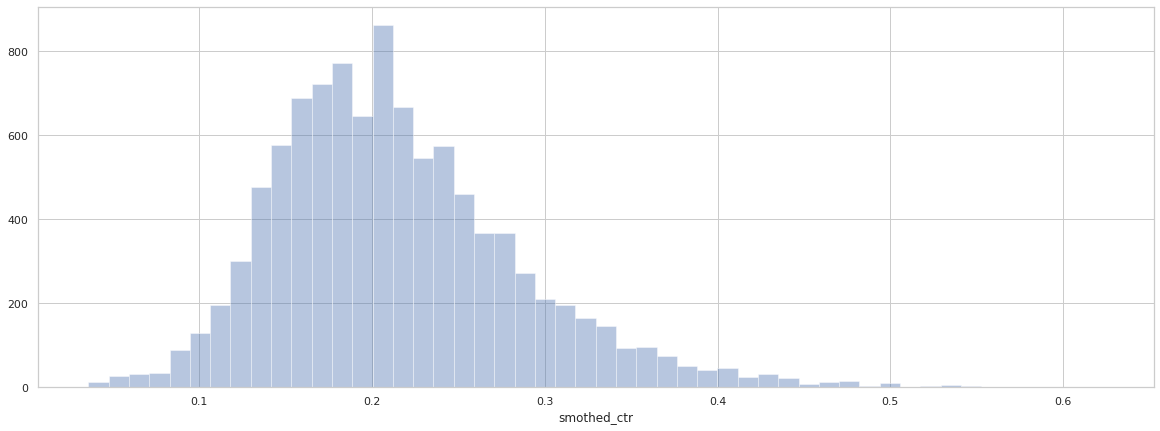

In [11]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr'>

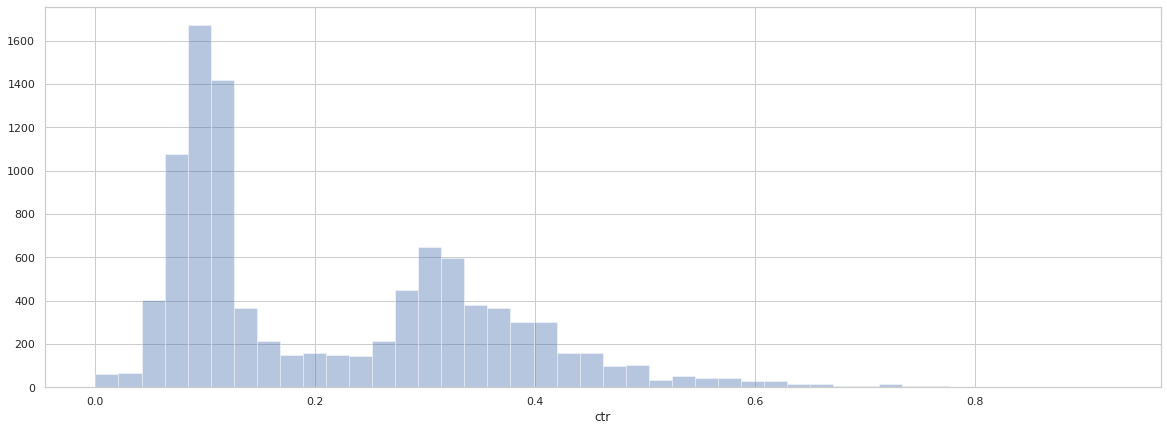

In [12]:
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

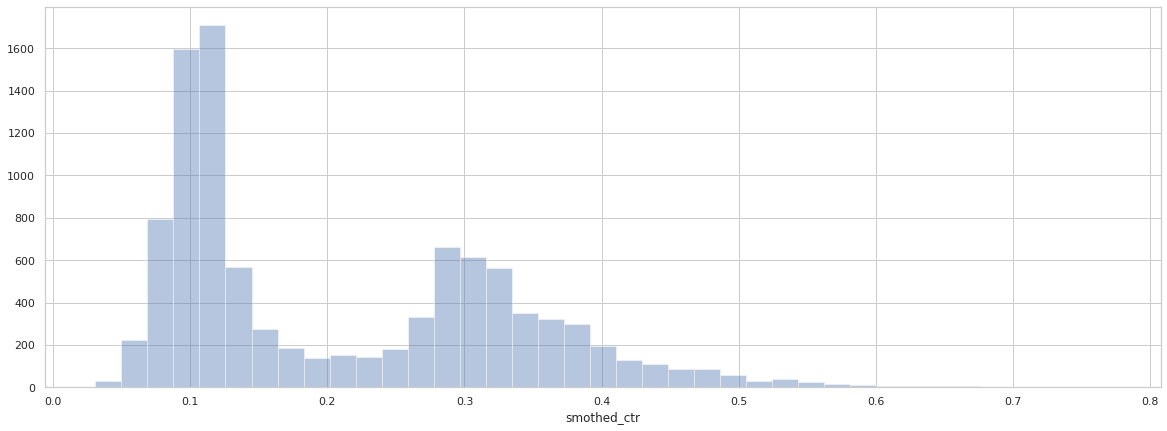

In [13]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [14]:
#Проведем t-test для сглаженного ctr
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

---
### Пуассоновский бутсрап

---

In [15]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

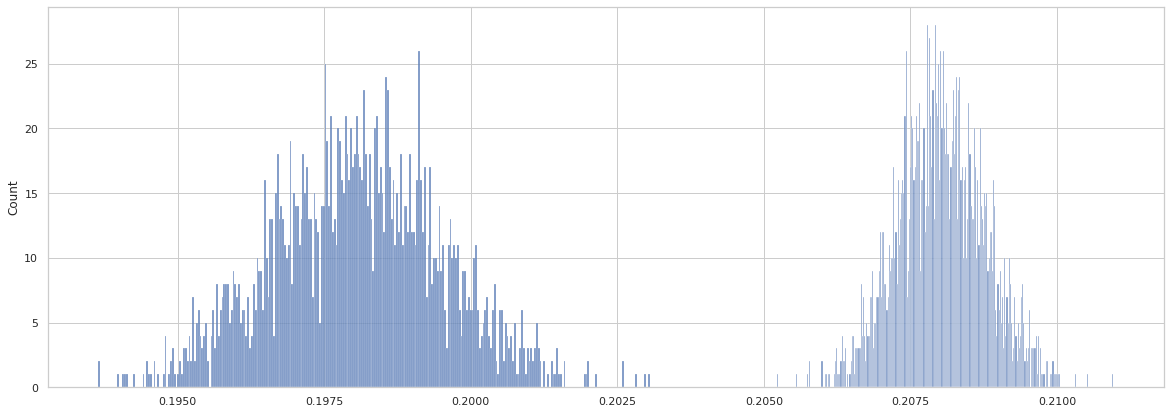

In [16]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, bins=300)
sns.histplot(ctr2, bins=300)
plt.show()

---
### Бакетное преобразование

---

In [18]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (1,2
        )
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q, connection=connection)


In [19]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

> ## Вывод:
В результате проведенного анализа мы увидели что ctr в контрольной группе распределен нормально. В то время как в экспериментальной разбиение получилось биноминальным. В следствии чего t-test ожидаемо не показал различия. Однако другие тесты: сглаженный ctr, манна-уитни, пуассоновский бутстрап и бакетное преобразование показали статзначимые различия. При визуальном изучении графика стало очевидно, что наша эксперементальная группа имеет две группы пользователей. Которым наше улучшение понравилось и которым не понравилось ctr стал в среднем ниже. Возможно некорретно отработала система сплитования и пользователи во 2й группе все таки имеют явные различия в характеристиках(одного пола, одного возраста и т.д.) В целом по графику распределения ctr видно, что пользователей у которых ctr упал больше. Исходя из вышесказанного данное обновление лучше не выкатывать на весь сервис.